In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
import joblib

# version 3 - adding cv2 import above - adding lightening and darkening and appending those images to x_train and y_train - added cell number 6 with functions there.

# also now added joblib import - saves the model for use in app.py flask script.

In [2]:
# paths to folders containing images 
pneumonia_folder = 'Resources/train/PNEUMONIA'
healthy_folder = 'Resources/train/NORMAL'

# load images from pneumonia folder
pneumonia_images = [os.path.join(pneumonia_folder, img) for img in os.listdir(pneumonia_folder)]

# load images from healthy folder
healthy_images = [os.path.join(healthy_folder, img) for img in os.listdir(healthy_folder)]

print(pneumonia_images)

print(healthy_images)

['Resources/train/PNEUMONIA\\person1000_bacteria_2931.jpeg', 'Resources/train/PNEUMONIA\\person1000_virus_1681.jpeg', 'Resources/train/PNEUMONIA\\person1001_bacteria_2932.jpeg', 'Resources/train/PNEUMONIA\\person1002_bacteria_2933.jpeg', 'Resources/train/PNEUMONIA\\person1003_bacteria_2934.jpeg', 'Resources/train/PNEUMONIA\\person1003_virus_1685.jpeg', 'Resources/train/PNEUMONIA\\person1004_bacteria_2935.jpeg', 'Resources/train/PNEUMONIA\\person1004_virus_1686.jpeg', 'Resources/train/PNEUMONIA\\person1005_bacteria_2936.jpeg', 'Resources/train/PNEUMONIA\\person1005_virus_1688.jpeg', 'Resources/train/PNEUMONIA\\person1006_bacteria_2937.jpeg', 'Resources/train/PNEUMONIA\\person1007_bacteria_2938.jpeg', 'Resources/train/PNEUMONIA\\person1007_virus_1690.jpeg', 'Resources/train/PNEUMONIA\\person1008_bacteria_2939.jpeg', 'Resources/train/PNEUMONIA\\person1008_virus_1691.jpeg', 'Resources/train/PNEUMONIA\\person1009_virus_1694.jpeg', 'Resources/train/PNEUMONIA\\person100_virus_184.jpeg', 'Reso

In [3]:
# preprocess function
def preprocess_image(image_paths, target_size):
    processed_images = []
    for image_path in image_paths:
        try:
            image = Image.open(image_path)
            # convert RGB image to grayscale - (not sure if I need this but couldn't hurt)
            image = image.convert('L')
            image = image.resize(target_size)
            image = np.array(image)
            processed_images.append(image)
        except Exception as e:
            print(f"Error processing image: {image_path}. Error: {e}")
    return processed_images

In [4]:
# set seed for reproducability
random.seed(42)

# select random subset of images
num_images_to_select = 300
selected_healthy_files = random.sample(healthy_images, num_images_to_select)
selected_pneumonia_files = random.sample(pneumonia_images, num_images_to_select)

X = []
y = []

# define target size
target_size = (228, 228)

# process selected pneumonia images
processed_pneumonia_images = preprocess_image(selected_pneumonia_files, target_size)
X.extend(processed_pneumonia_images)
y.extend([1] * len(processed_pneumonia_images))

# process selected healthy images
processed_healthy_images = preprocess_image(selected_healthy_files, target_size)
X.extend(processed_healthy_images)
y.extend([0] * len(processed_healthy_images))

X = np.array(X).reshape(-1, 228, 228, 1)
y = np.array(y)

# confirm shapes of X and y
print(X.shape, y.shape)

(600, 228, 228, 1) (600,)


In [5]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print shapes of training & testing sets to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (480, 228, 228, 1)
X_test shape: (120, 228, 228, 1)
y_train shape: (480,)
y_test shape: (120,)


In [6]:
# lighten image function
def lighten_image(image, factor=1.5):
    return np.clip(image * factor, 0, 255).astype(np.uint8)

# darken image function
def darken_image(image, factor=0.5):
    return np.clip(image * factor, 0, 255).astype(np.uint8)

# augment data function
def augment_dataset(X_train, y_train):
    augmented_images = []
    augmented_labels = []
    
    for image, label in zip(X_train, y_train):
        original_image = image
        lightened_image = lighten_image(image)
        darkened_image = darken_image(image)
        
        augmented_images.extend([original_image, lightened_image, darkened_image])
        augmented_labels.extend([label, label, label])
    
    X_train_augmented = np.array(augmented_images)
    y_train_augmented = np.array(augmented_labels)
    
    return X_train_augmented, y_train_augmented

In [7]:
# define CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(228, 228, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# augment dataset - concatenate lighter and darker images, also triple y_train - call in function
X_train_augmented, y_train_augmented = augment_dataset(X_train, y_train)

# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
history = model.fit(X_train_augmented, y_train_augmented, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
45/45 [==============================] - 55s 1s/step - loss: 86.2268 - accuracy: 0.7576 - val_loss: 0.3656 - val_accuracy: 0.8833
Epoch 2/5
45/45 [==============================] - 43s 957ms/step - loss: 0.3286 - accuracy: 0.9569 - val_loss: 0.7328 - val_accuracy: 0.9333
Epoch 3/5
45/45 [==============================] - 64s 1s/step - loss: 0.0851 - accuracy: 0.9806 - val_loss: 0.3945 - val_accuracy: 0.9333
Epoch 4/5
45/45 [==============================] - 65s 1s/step - loss: 0.0209 - accuracy: 0.9972 - val_loss: 0.4066 - val_accuracy: 0.9417
Epoch 5/5
45/45 [==============================] - 62s 1s/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.5644 - val_accuracy: 0.9500


In [8]:
# make predictions on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

4/4 [==============================] - 1s 289ms/step


In [11]:
# save model for use in flask app.py
joblib.dump(model, "pneumonia_model.joblib")

INFO:tensorflow:Assets written to: ram://bd980eca-4b07-48d3-b336-077979267939/assets


INFO:tensorflow:Assets written to: ram://bd980eca-4b07-48d3-b336-077979267939/assets


['pneumonia_model.joblib']

In [12]:
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# calculate precision/recall/F1
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# print evaluation metrics
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 95.00%
Precision: 0.95
Recall: 0.95
F1 Score: 0.95


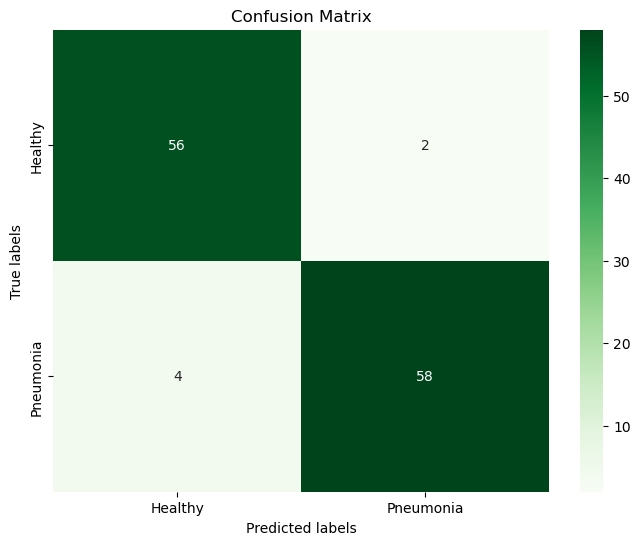

In [24]:
# get confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Healthy', 'Pneumonia'], yticklabels=['Healthy', 'Pneumonia'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

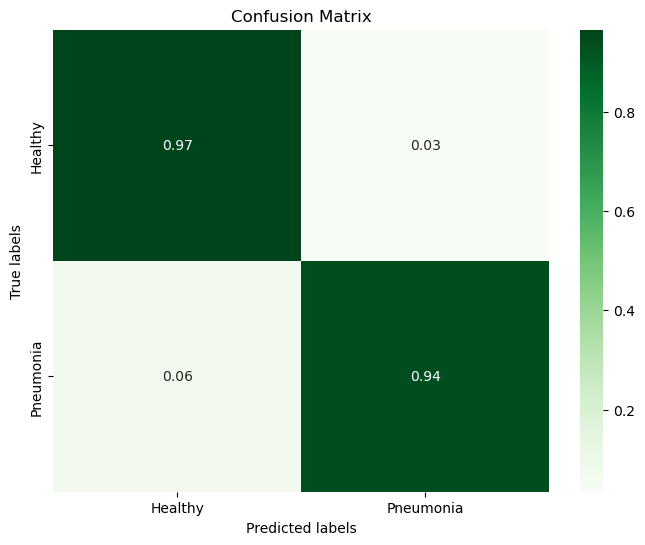

In [28]:
# calculate confusion matrix - normalized
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# calculate pnormalized ratio
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# plot confusion matrix with decimals
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Greens', 
            xticklabels=['Healthy', 'Pneumonia'], yticklabels=['Healthy', 'Pneumonia'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 226, 226, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 193600)            0         
                                                                 
 dense (Dense)               (None, 64)                1

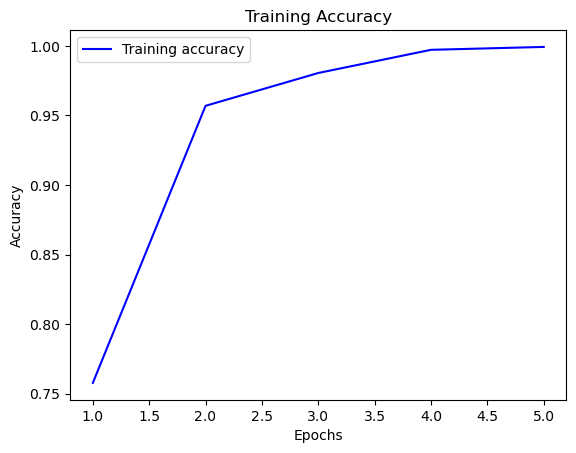

In [14]:
# access accuracy values from history 
accuracy = history.history['accuracy']
epochs = range(1, len(accuracy) + 1)

# plot accuracy over epochs
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
# paths to folders containing images 
pneumonia_folder = 'Resources/train/PNEUMONIA'
healthy_folder = 'Resources/train/NORMAL'

# load images from pneumonia folder
pneumonia_eval_images = [os.path.join(pneumonia_folder, img) for img in os.listdir(pneumonia_folder)]

# load images from healthy folder
healthy_eval_images = [os.path.join(healthy_folder, img) for img in os.listdir(healthy_folder)]

print(pneumonia_eval_images)

print(healthy_eval_images)

['Resources/train/PNEUMONIA\\person1000_bacteria_2931.jpeg', 'Resources/train/PNEUMONIA\\person1000_virus_1681.jpeg', 'Resources/train/PNEUMONIA\\person1001_bacteria_2932.jpeg', 'Resources/train/PNEUMONIA\\person1002_bacteria_2933.jpeg', 'Resources/train/PNEUMONIA\\person1003_bacteria_2934.jpeg', 'Resources/train/PNEUMONIA\\person1003_virus_1685.jpeg', 'Resources/train/PNEUMONIA\\person1004_bacteria_2935.jpeg', 'Resources/train/PNEUMONIA\\person1004_virus_1686.jpeg', 'Resources/train/PNEUMONIA\\person1005_bacteria_2936.jpeg', 'Resources/train/PNEUMONIA\\person1005_virus_1688.jpeg', 'Resources/train/PNEUMONIA\\person1006_bacteria_2937.jpeg', 'Resources/train/PNEUMONIA\\person1007_bacteria_2938.jpeg', 'Resources/train/PNEUMONIA\\person1007_virus_1690.jpeg', 'Resources/train/PNEUMONIA\\person1008_bacteria_2939.jpeg', 'Resources/train/PNEUMONIA\\person1008_virus_1691.jpeg', 'Resources/train/PNEUMONIA\\person1009_virus_1694.jpeg', 'Resources/train/PNEUMONIA\\person100_virus_184.jpeg', 'Reso

In [16]:
# extra validation - using unbalanced data set for input

# set seed for reproducability
random.seed(42)

# select random subset of images
num_healthy_images_to_select = 1200
num_pneumonia_images_to_select = 300

selected_healthy_eval_files = random.sample(healthy_images, num_healthy_images_to_select)
selected_pneumonia_eval_files = random.sample(pneumonia_images, num_pneumonia_images_to_select)

X_eval = []
y_eval = []

# define target size
target_size = (228, 228)

# process selected pneumonia images
processed_pneumonia_eval_images = preprocess_image(selected_pneumonia_eval_files, target_size)
X_eval.extend(processed_pneumonia_eval_images)
y_eval.extend([1] * len(processed_pneumonia_eval_images))

# process selected healthy images
processed_healthy_eval_images = preprocess_image(selected_healthy_eval_files, target_size)
X_eval.extend(processed_healthy_eval_images)
y_eval.extend([0] * len(processed_healthy_eval_images))

X_eval = np.array(X_eval).reshape(-1, 228, 228, 1)
y_eval = np.array(y_eval)

# confirm shapes of X and y
print(X_eval.shape, y_eval.shape)

(1500, 228, 228, 1) (1500,)


In [17]:
# additional unbalanced evaluation - 1200 healthy images - 300 pneumonia
history_eval = model.evaluate(X_eval, y_eval)

# make predictions on evaluation dataset
y_eval_pred = model.predict(X_eval)

# convert predictions to class labels
y_eval_pred_classes = np.argmax(y_eval_pred, axis=1)

47/47 [==============================] - 10s 221ms/step


In [18]:
# calculate accuracy
accuracy = accuracy_score(y_eval, y_eval_pred_classes)

# calculate precision/recall/F1
precision = precision_score(y_eval, y_eval_pred_classes, average='weighted')
recall = recall_score(y_eval, y_eval_pred_classes, average='weighted')
f1 = f1_score(y_eval, y_eval_pred_classes, average='weighted')

# print evaluation metrics
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 92.80%
Precision: 0.94
Recall: 0.93
F1 Score: 0.93


In [19]:
#verification for klaus
sum(y_eval)/len(y_eval)

0.2

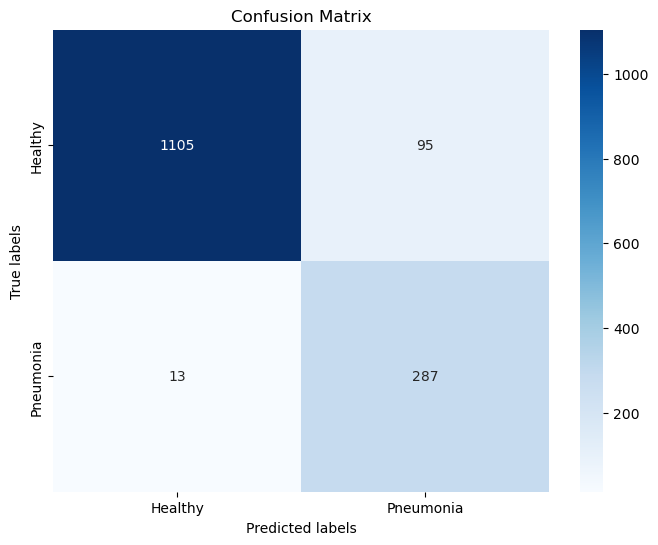

In [21]:
# get confusion matrix
conf_matrix = confusion_matrix(y_eval, y_eval_pred_classes)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Pneumonia'], yticklabels=['Healthy', 'Pneumonia'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()